## 3. Обработка аннотаций

Обявленние всех необходимых путей и создание папок

In [ ]:
# указываем пути
img_dir = "images_v2/images2" # Исходные изображения
class_file = "images_v2/labels.txt" # файл с информацией о классах
bbox_file = "images_v2/bboxes.tsv" # файл с информацией о bouding box
out_labels_dir = "images_v2/labels_bbox" # новая папка с обработанными анотациями
out_removed_img_dir = "images_v2/test" # новая папка c избражениями для теста

# Создание папок
os.makedirs(out_labels_dir, exist_ok=True)
os.makedirs(out_removed_img_dir, exist_ok=True)

### Рассмотрение особенностей датасета

**Чтение файлов с информацией о классах и разметкой изображений**

In [ ]:
# Чтение классов
with open(class_file, "r") as f:
    class_lines = {line.split()[0]: line.split()[1] for line in f.readlines()}

# Чтение разметки
with open(bbox_file, "r") as f:
    bbox_lines = [line.strip().split('\t') for line in f.readlines()]

**Проверка на дубликаты**

In [ ]:
# Создаем счетчик для подсчета количества вхождений каждого изображения в разметке
bbox_counter = Counter(line[0] for line in bbox_lines if len(line) >= 5)  

# Фильтруем только те изображения, которые встречаются более одного раза (дубликаты)
duplicates = {img_name: count for img_name, count in bbox_counter.items() if count > 1}

# Проверяем, есть ли дубликаты
if duplicates:
    print("Обнаружены дубликаты:")
    # Выводим список изображений с количеством повторений
    for img, count in duplicates.items():
        print(f"{img}: {count} раз(а)")
else:
    print("Дубликаты не найдены.")

Дубликаты не найдены, следовательно дополнительная обработка не требуется

### Приведение к удобному формату, совместимому с нейросетью

**Выбор удобного формата, совместимого с нейросетями:**

Принято решение использовать Ultralytics YOLO формат, поскольку:
1. Гибкость и масштабируемость (Поддержка как одного класса (одноуровневая детекция), так и многоклассовой детекции. Подходит для различных типов объектов и аннотаций.)

2. Совместимость с популярными фреймворками (Поддерживается в Ultralytics YOLO, Roboflow, OpenCV, Albumentations и других инструментах для обработки данных.)

**Структура Ultralytics YOLO формата:**

1. 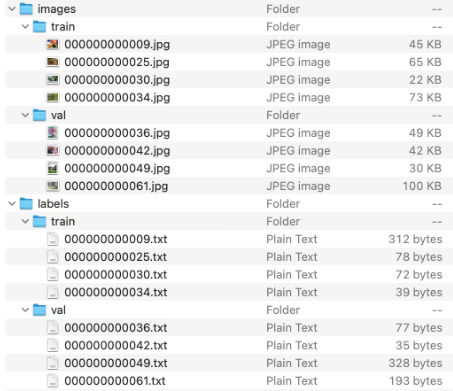

2. Формат анотации: класс x_center y_center width height

**Приведение к выбранному формату**

In [ ]:
# Обработка и создание txt файлов
for bbox_line in bbox_lines:
    if len(bbox_line) < 5: # проверка на две или более меток
        continue

    img_name, x, y, w, h = bbox_line
    img_path = os.path.join(img_dir, img_name)

    if not os.path.exists(img_path): # проверка на существование пути
        continue

    if img_name not in class_lines:
        print(f"Нет класса для: {img_name}, перемещаем в test")
        shutil.move(img_path, os.path.join(out_removed_img_dir, img_name))
        continue

    class_id = class_lines[img_name]

    # Нормализация координат
    x, y, w, h = map(float, [x, y, w, h])
    with Image.open(img_path) as img:
        img_w, img_h = img.size  # Получаем размеры изображения

    x_center = (x + w / 2) / img_w
    y_center = (y + h / 2) / img_h
    w_norm = w / img_w
    h_norm = h / img_h

    # Формат строки
    label_str = f"{class_id} {x_center:.7f} {y_center:.7f} {w_norm:.7f} {h_norm:.7f}\n"

    # Запись в файл
    label_file = os.path.join(out_labels_dir, img_name.replace(".jpg", ".txt"))
    with open(label_file, "w") as f:
        f.write(label_str)

print("Формирование аннотаций завершено.")

Данные обработаны, приведены к выбранному формату

**Итог:**
1. Проведена проверка на дубликаты
2. Дубликаты не выявлены
3. Выбран удобный формат данных (Ultralytics YOLO формат)
4. Данные приведены к удобному формату

## 4. Сбор и подготовка дополнительных данных

### А. Создание дополнительного набора изображений

**Алгоритм для захвата и обработки видеопотоков в реальном времени**

Разработан скрипт для захвата и обработки видеопотоков в реальном времени

In [ ]:
# Создаем папку для сохранения кадров
save_dir = "images_v2/captured_frames"
os.makedirs(save_dir, exist_ok=True)

n = 1 # переменная интервала между кадрами

# Функция проверки качества кадра (размытие и освещенность)
def is_good_frame(frame, blur_threshold=100, brightness_threshold=50):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur_value = cv2.Laplacian(gray, cv2.CV_64F).var()
    brightness = np.mean(gray)
    return blur_value > blur_threshold and brightness > brightness_threshold

# Открываем видеопоток
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Ошибка: Не удалось открыть камеру")
    exit()

frame_count = 0  # Счетчик кадров
total_frames = 20  # Максимальное количество снимков

# захват видеопотока
while frame_count < total_frames:
    ret, frame = cap.read()

    # Фильтруем и сохраняем кадры
    if is_good_frame(frame):
        frame_count += 1
        filename = os.path.join(save_dir, f"frame_{frame_count}.jpg")
        cv2.imwrite(filename, frame)
        print(f"Сохранен кадр {filename}")
        time.sleep(n)  # Ждем n секунд перед следующим кадром

    # Останавливаем по 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождаем ресурсы
cap.release()
cv2.destroyAllWindows()
print("Съемка завершена!")

Получили 20 изображений из видеопотока

**Визуализируем полученные изображения**

In [ ]:
# Указываем путь к папке с изображениями
folder_path = "images_v2/captured_frames"
# Получаем список файлов изображений (не более 100 файлов)
image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))][:100]
# Загружаем изображения, изменяя их размер до 200x200 пикселей
images = [cv2.resize(cv2.imread(os.path.join(folder_path, f)), (200, 200)) for f in image_files if cv2.imread(os.path.join(folder_path, f)) is not None]

# Определяем количество строк и столбцов в коллаже (по 10 колонок)
rows, cols = -(-len(images) // 10), 10
# Создаем пустое изображение для коллажа
collage = np.zeros((rows * 200, cols * 200, 3), dtype=np.uint8)

# Заполняем коллаж изображениями
for idx, img in enumerate(images):
    y, x = (idx // cols) * 200, (idx % cols) * 200
    collage[y:y+200, x:x+200] = img

# Отображаем итоговый коллаж
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Полученные кадры различны, что поспособствует лучшему обучению модели

### Б. Маркировка изображений в наборе данных (аннотирование)

**Выбор свободного класса**

Например возьмем индекс 52, проверим занято ли данное значение существующим классом

In [ ]:
# Проверка на занятость индекса
for i in labels:
    f = i.split()
    if f[1] == '52':
        print('Такой класс уже существует')
        break
else:
    print('Класс свободен')       

Класс 52 не занят, будем использовать данный индекс

**Создание аннотаций для дополнительного набора данных**

Разработан скрипт аннотатирования дополнительных изображений

In [ ]:
# Папки с изображениями и аннотациями
image_dir = "images_v2/captured_frames"
image_dir_ano = "images_v2/captured_frames_ano"
annotations_dir = "images_v2/annotations"

os.makedirs(annotations_dir, exist_ok=True)
os.makedirs(image_dir_ano, exist_ok=True)

# Разрешенные форматы изображений
valid_extensions = (".jpg", ".png", ".jpeg")

# Инициализируем детектор лиц Mediapipe
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.6)

# Проходим по всем изображениям
for img_name in os.listdir(image_dir):
    # Пропускаем файлы без нужных расширений
    if not img_name.lower().endswith(valid_extensions):
        print(f"Пропущен файл: {img_name}")
        continue

    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)

    # Проверяем, удалось ли загрузить изображение
    if image is None:
        print(f"Ошибка: не удалось загрузить {img_path}")
        continue

    # Конвертируем изображение в оттенки серого для улучшения контраста
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Улучшаем контраст с помощью CLAHE (гистограмма выравнивания)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # Убираем шум с помощью размытия
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Конвертируем изображение в RGB для Mediapipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    # Создаем файл аннотации
    annotation_path = os.path.join(annotations_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
    
    if results.detections:
        with open(annotation_path, "w") as f:
            for detection in results.detections:
                # Получаем координаты лица в относительных величинах
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape  # Размеры изображения
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # Записываем координаты лица
                f.write(f"52 {x} {y} {w} {h}\n")

                # Рисуем рамку вокруг лица
                cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Сохраняем изображение с аннотацией
        annotated_img_path = os.path.join(image_dir_ano, f"annotated_{img_name}")
        cv2.imwrite(annotated_img_path, image)
        print(f"Сохранена аннотация: {annotation_path}")
    else:
        print(f"Лица не найдены в {img_name}")

print("Аннотирование завершено!")

Произведено аннотирование изображений. 

**Визуализируем результаты:**

In [ ]:
# Указываем путь к папке с изображениями
folder_path = "images_v2/captured_frames_ano"
# Получаем список файлов изображений (не более 100 файлов)
image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg'))][:100]
# Загружаем изображения, изменяя их размер до 200x200 пикселей
images = [cv2.resize(cv2.imread(os.path.join(folder_path, f)), (200, 200)) for f in image_files if cv2.imread(os.path.join(folder_path, f)) is not None]

# Определяем количество строк и столбцов в коллаже (по 10 колонок)
rows, cols = -(-len(images) // 10), 10
# Создаем пустое изображение для коллажа
collage = np.zeros((rows * 200, cols * 200, 3), dtype=np.uint8)

# Заполняем коллаж изображениями
for idx, img in enumerate(images):
    y, x = (idx // cols) * 200, (idx % cols) * 200
    collage[y:y+200, x:x+200] = img

# Отображаем итоговый коллаж
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(collage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Скрипт с достаточной точностью разметил лица на изображениях, будем использовать полученные изображения при обучении последующей нейросети

### В. Аугментация, Анализ

**Проведем качественный и количественный анализ**

Визуализация соотношения классов

In [ ]:
# Чтение данных из файла
file_path = 'images_v2/labels.txt'

# Словарь для хранения классов
labels = []

# Чтение файла и извлечение классов
with open(file_path, 'r') as f:
    for line in f:
        image, label = line.split()
        labels.append(int(label))

# Подсчет количества каждого класса
label_counts = Counter(labels)

# Извлечение меток и их частот
labels_list = list(label_counts.keys())
counts_list = list(label_counts.values())

# Построение гистограммы
plt.figure(figsize=(14, 6))
plt.bar(labels_list, counts_list)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Выявленно:

Присутствует дисбаланс классов, для его устранения добавим аугментированные изображения для увеличение представительства классов

**Выбор кол-ва дополнительных изображений**

In [ ]:
# Вывод самого частовстречающегося класса
print(*label_counts.most_common(1))

Так как наибольший показатель представительства равен 8 примерам, то и добавим в тренироваочную выборку 8 дополнительных изображений, остальные в тестовую выборку.

Данное кол-во было выбрано, чтобы избежать усугубления дисбаланса классов

**Перенос дополнительных изображений в основной датасет**

In [ ]:
# инициализация функции переноса изображений
def move_files(src_folder, dst_folder, num_files=8):
    files = sorted(os.listdir(src_folder))[:num_files]  # Берем первые num_files файлов
    
    for file in files:
        src_path = os.path.join(src_folder, file)
        dst_path = os.path.join(dst_folder, file)
        shutil.move(src_path, dst_path)
        print(f"Перемещен: {file}")

# Пути к папкам
captured_frames = "images_v2/captured_frames"
images_dst = "images_v2/images"
annotations_src = "images_v2/annotations"
labels_dst = "images_v2/labels_bbox"

# Перемещение файлов
move_files(captured_frames, images_dst, num_files=8)
move_files(annotations_src, labels_dst, num_files=8)

print("Перемещение завершено.")

Дополнительные изображения перенесены в тренироваочную выборку

**Аугментация**

Для устранения дисбаланса классов принято решение проводить аугментацию только классов с меньшим представительством, цель данной аугментации: уровнять пердставительство классов

Разработан скрипт аугментации изображений классов с меньшим представительством 

In [ ]:
# Пути к папкам с изображениями и метками
images_folder = "images_v2/images"
labels_folder = "images_v2/labels_bbox"  # Путь к папке с метками
output_folder = "images_v2/images"  # Сохранение обработанных изображений в ту же папку

# Функция для чтения меток из файлов YOLO
def read_labels_from_yolo(labels_folder):
    label_counts = Counter()
    for filename in os.listdir(labels_folder):
        if filename.endswith(".txt"):
            label_file_path = os.path.join(labels_folder, filename)
            with open(label_file_path, "r") as f:
                labels = f.readlines()
                for label in labels:
                    class_id = int(label.split()[0])  # Первый элемент - это класс
                    label_counts[class_id] += 1
    return label_counts

# Функция для изменения размера изображения
def resize_image(image, size=(256, 256)):
    return cv2.resize(image, size)

# Функция для улучшения качества изображения (контраст, яркость)
def enhance_image(image):
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=30)  # Повышение контраста и яркости
    return image

# Функция для фильтрации шумов
def denoise_image(image):
    image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return image

# Аугментации с использованием Albumentations
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),  # Исправление предупреждения
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
])

# Чтение меток и подсчёт классов
label_counts = read_labels_from_yolo(labels_folder)

# Получаем максимальное количество изображений для какого-либо класса
max_count = max(label_counts.values())

# Определяем классы, для которых нужно провести аугментацию
underrepresented_classes = {class_id for class_id, count in label_counts.items() if count < max_count}

# Функция для обработки изображений
def process_image(filename, augmented_class_counts):
    image_path = os.path.join(images_folder, filename)
    image = cv2.imread(image_path)

    # Путь к меткам для этого изображения
    label_file_path = os.path.join(labels_folder, f"{filename.split('.')[0]}.txt")

    # Проверяем, принадлежит ли изображение классу с меньшим представлением
    if os.path.exists(label_file_path):
        with open(label_file_path, "r") as f:
            labels = f.readlines()
            classes_in_image = {int(label.split()[0]) for label in labels}
            
            # Добавляем аугментацию только если класс недопредставлен
            for class_id in classes_in_image:
                if class_id in underrepresented_classes and augmented_class_counts[class_id] < max_count:
                    # Рассчитываем сколько изображений нужно добавить
                    remaining = max_count - augmented_class_counts[class_id]

                    if remaining > 0:
                        # Применяем преобразования
                        resized_image = resize_image(image)
                        enhanced_image = enhance_image(resized_image)
                        denoised_image = denoise_image(enhanced_image)

                        # Сохранение обработанных изображений
                        for i in range(remaining):
                            processed_image_path = os.path.join(output_folder, f"processed_{class_id}_{filename}_{i}.jpg")
                            cv2.imwrite(processed_image_path, denoised_image)

                            # Аугментация
                            augmented_image = transform(image=denoised_image)['image']
                            
                            # Сохранение аугментированного изображения
                            augmented_image_path = os.path.join(output_folder, f"aug_{class_id}_{filename}_{i}.jpg")
                            cv2.imwrite(augmented_image_path, augmented_image)

                            # Обновляем счетчик для этого класса
                            augmented_class_counts[class_id] += 1
                        
                    break  # Выходим из цикла после обработки для данного класса
    else:
        print(f"Label file for {filename} not found.")

# Ограничиваем количество изображений до 9610
image_files = os.listdir(images_folder)[:9610]

# Словарь для отслеживания количества аугментированных изображений для каждого класса
augmented_class_counts = {class_id: label_counts.get(class_id, 0) for class_id in underrepresented_classes}

# Используем ThreadPoolExecutor для параллельной обработки с tqdm
with ThreadPoolExecutor(max_workers=8) as executor:
    for _ in tqdm(executor.map(process_image, image_files, [augmented_class_counts] * len(image_files)), total=len(image_files), desc="Processing Images"):
        # Проверяем, если для всех классов достижено максимальное представительство
        if all(count >= max_count for count in augmented_class_counts.values()):
            print("All classes have reached the maximum representation. Stopping augmentation.")
            break


Успешна проведена аугментация изображений.

**Визуализируем соотношение классов по результатам аугментации**

In [ ]:
# Отсортируем по возрастанию словарь с классами и их представитеством
augmented_class_counts2 = dict(sorted(augmented_class_counts.items(), key=lambda item: item[1]))
augmented_class_counts2

In [ ]:
# Извлечение меток и их частот
labels_list = list(augmented_class_counts2.keys())
counts_list = list(augmented_class_counts2.values())

# Построение гистограммы
plt.figure(figsize=(14, 6))
plt.bar(labels_list, counts_list)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

После аугментации представительство абсолютного большинства классов выравнелось.

Аугментация привела к желаемому результату

**Разметка аугментированных изображений**

Для разметки аугментированных изображений используем тот же скрипт (с небольшими изменениями), что и для дополнительных данных, поскольку он показал себя хорошо при их разметке

In [ ]:
# Папки с изображениями и аннотациями
image_dir = "images_v2/images"
annotations_dir = "images_v2/annotations_for_img"

os.makedirs(annotations_dir, exist_ok=True)

# Разрешенные форматы изображений
valid_extensions = (".jpg", ".png", ".jpeg")

# Инициализируем детектор лиц Mediapipe
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.6)

# Проходим по всем изображениям
for img_name in os.listdir(image_dir):
    # Проверяем, является ли изображение аугментированным (содержит '_processed_' в названии)
    if 'processed_' not in img_name:
        continue  # Пропускаем не аугментированные изображения
    
    # Извлекаем класс из названия файла, например, из processed_10174_005327.jpg_0 извлекаем 10174
    class_id = img_name.split('_')[1]
    
    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)

    # Проверяем, удалось ли загрузить изображение
    if image is None:
        print(f"Ошибка: не удалось загрузить {img_path}. Изображение будет удалено.")
        os.remove(img_path)  # Удаляем изображение из папки
        continue  # Пропускаем обработку этого изображения

    # Конвертируем изображение в RGB для Mediapipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    # Создаем файл аннотации
    annotation_path = os.path.join(annotations_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))
    
    if results.detections:
        with open(annotation_path, "w") as f:
            for detection in results.detections:
                # Получаем координаты лица в относительных величинах
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, _ = image.shape  # Размеры изображения
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # Записываем координаты лица с классом
                f.write(f"{class_id} {x} {y} {w} {h}\n")
    else:
        print(f"Лица не найдены в {img_name}, изображение является выбросом и будет удалено.")
        os.remove(img_path)  # Удаляем изображение, если лица не найдены

print("Аннотирование завершено!")

Совершенно аннотатирование аугментированных изображений, также удалены выбросы

**Итог:**

1. Разработан алгоритм для захвата и обработки видеопотоков в реальном времени
2. Дополнительные изображения добавленны в тренировочный датасет
3. Дополнительные изображения аннотированы
4. Проведен количественный и качественный анализ исходного набора данных
5. Выполнено изменение размера изображений, улучшение качества, фильтрацию шумов, аугментацию и другие преобразования
6. Устранен дисбаланс классов
7. Аннотированы аугментированные изображения

# Итоги

1. Данные загруженны и проанализированны
2. Все изображения приведены к елиному формату (RGB), выбор формата изображений обоснован
3. Данные приведены к Ultralytics yolo формату, выбор формата данных обоснован
4. Проведен анализ особенностей датасета
5. Датасет дополнен данными с видеопотока
6. Проведено аннотирование дополнительных изображений
7. Проведен количественный и качественный анализ датасета
8. Выполнено построение процесса предварительной обработки данных (устранен дисбаланс классов, проведена фильтрация и аугментация  изображений)